In [177]:
import dask
import numpy as np
import pandas as pd
import tempfile
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import xarray as xr
import yaml

import common
import vcm

from fv3fit.train_microphysics import TrainConfig

In [178]:
client = dask.distributed.Client()

In [17]:
base = "zc-emu-classify-check-m{init}-6h-v2-online"

In [104]:
def open_12init_group(group):
    months = [f"{i:02d}" for i in range(1, 13)]
    groups = [base.format(init=m) for m in months]

    sample = xr.Dataset(coords={"x": range(48), "y": range(48)}).stack({"sample": ["y", "x"]}).coords["sample"]
    ds = []
    for g in groups:
        url = common.get_group_url(g)
        state = xr.open_zarr(f"{url}/state_output.zarr", consolidated=True)
        state.coords["sample"] = sample
        state = state.unstack("sample").drop_vars("time")
        ds.append(state)

    return xr.concat(ds, dim="init")



In [106]:
data = open_12init_group(base)

In [107]:
POSITIVE_TENDENCY = "positive_tendency"
ZERO_TENDENCY = "zero_tendency"
ZERO_CLOUD = "zero_cloud"
NEGATIVE_TENDENCY = "negative_tendency"
NONTRIVIAL_TENDENCY = "nontrivial_tendency"

# this constant is reused elswhere so is effectively public api
CLASS_NAMES = {
    POSITIVE_TENDENCY,
    ZERO_TENDENCY,
    ZERO_CLOUD,
    NEGATIVE_TENDENCY,
}

def _get_classify_output(logit_classes, one_hot_axis=1):
    names = sorted(CLASS_NAMES)
    one_hot = logit_classes == np.max(logit_classes, axis=one_hot_axis, keepdims=True)
    d = {name: np.take(one_hot, i, one_hot_axis) for i, name in enumerate(names)}
    d["nontrivial_tendency"] = d[POSITIVE_TENDENCY] | d[NEGATIVE_TENDENCY]
    return d

def classify(cloud_in, cloud_out, timestep, math=tf.math):
    state_thresh = 1e-15
    tend_thresh = 1e-15

    tend = (cloud_out - cloud_in) / timestep
    some_cloud_out = math.abs(cloud_out) > state_thresh
    negative_tend = tend < -tend_thresh

    return {
        POSITIVE_TENDENCY: tend > tend_thresh,
        ZERO_TENDENCY: math.abs(tend) <= tend_thresh,
        ZERO_CLOUD: negative_tend & ~some_cloud_out,
        NEGATIVE_TENDENCY: negative_tend & some_cloud_out,
    }

In [175]:
def get_tile2_arctic_strato_classified(data):
    raw_classes = data["gscond_classes"].isel(tile=2, z=slice(-29, -11)).load()
    assert raw_classes.sizes["init"] == 12
    assert raw_classes.shape[-3] == 4

    classes = _get_classify_output(raw_classes.values, one_hot_axis=-3)
    assert classes["zero_cloud"].shape[-3:] == (18, 48, 48)

    classes = xr.Dataset({
        k: xr.DataArray(v, dims=["init", "time", "z", "y", "x"])
        for k,v in classes.items()
    })

    lat = data["latitude"].isel(tile=2, time=0, init=0).load()
    classes["lat"] = np.rad2deg(lat)

    return classes

In [179]:
arc_cl = get_tile2_arctic_strato_classified(data)

In [182]:
def get_class_fracs(classes, keep_vert=True):
    mask = classes.lat > 60
    num_horiz = mask.sum()
    num_vert = classes.dims["z"]

    if keep_vert:
        total = num_horiz
        sum_dims = ["x", "y"]
    else:
        total = num_horiz * num_vert
        sum_dims = ["x", "y", "z"]
    
    fracs = classes.where(mask).sum(dim=sum_dims)/total
    return fracs.mean(dim="init")


In [184]:
frac_cl = get_class_fracs(arc_cl)

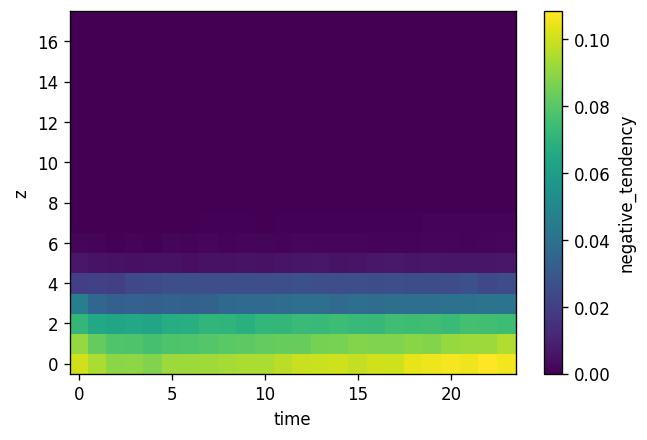

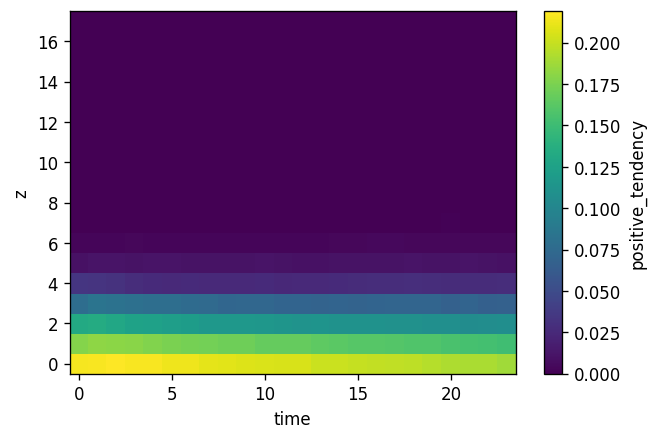

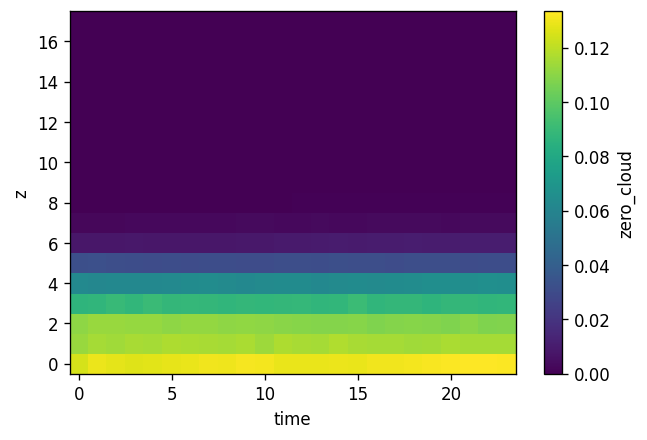

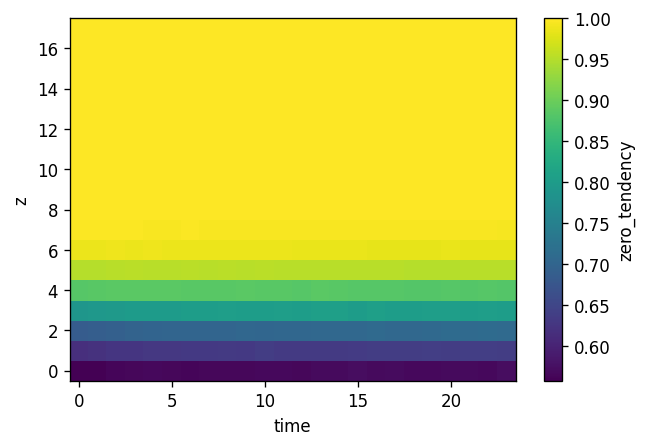

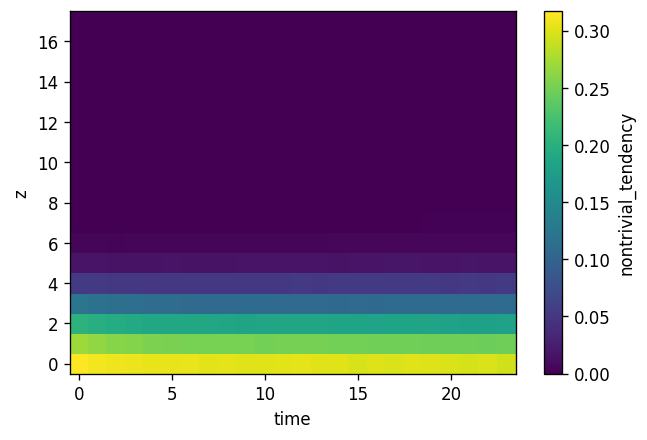

In [186]:
for k, v in frac_cl.items():
    if k == "lat":
        continue
    fig, ax = plt.subplots(dpi=120)
    v.plot(x="time", y="z")
    plt.show()

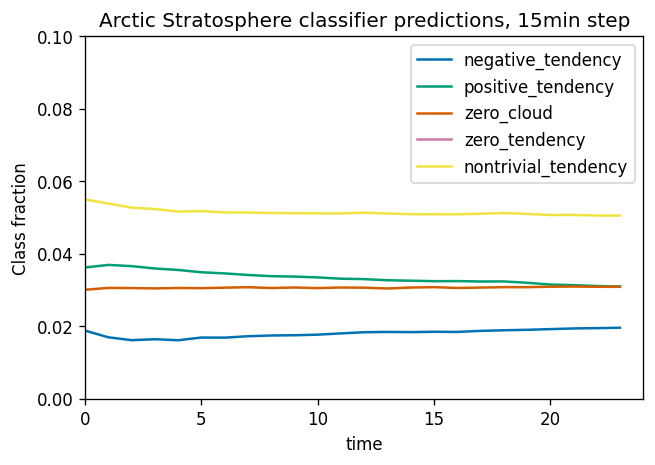

In [218]:
non_vert_fracs = get_class_fracs(arc_cl, keep_vert=False)

fig, ax = plt.subplots(dpi=120)
for k, da in non_vert_fracs.items():
    if k == "lat":
        continue
    da.plot(ax=ax, label=k)
plt.legend()
plt.ylim(0, 0.1)
plt.xlim(0, 24)
plt.ylabel("Class fraction")
plt.title("Arctic Stratosphere classifier predictions, 15min step")
plt.show()

## Bias spinup

In [198]:
opened_run_data = common.open_12init_from_group_prefix(base.replace("-online", ""))

In [199]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()

In [200]:
online_data = xr.concat([
    run_data[1].drop_vars("time") for run_data in opened_run_data.values()
], dim="init")

total_key = "tendency_of_{}_due_to_zhao_carr_{}"
gscond_key = "tendency_of_{}_due_to_gscond_{}"


In [201]:

def select_polar_stratosphere(data, arctic: bool):

    strato = data.isel(z=slice(11, 29)) # layers 50 - 250 hPa
    strato = vcm.zonal_average_approximate(grid.lat, strato)
    if arctic:
        polar = strato.isel(lat=slice(-15, None))
    else:
        polar = strato.isel(lat=slice(15))

    return polar

def get_all_tends(data, source, varkey="specific_humidity"):
    gkey = gscond_key.format(varkey, source)
    tkey = total_key.format(varkey, source)
    gscond = select_polar_stratosphere(data[gkey], True)
    total = select_polar_stratosphere(data[tkey], True)
    precpd = total - gscond
    return gscond, precpd, total

emu_gs, emu_pr, emu_tot = get_all_tends(online_data, "emulator")
phy_gs, phy_pr, phy_tot = get_all_tends(online_data, "physics")
emu_cl_gs, emu_cl_pr, _ = get_all_tends(online_data, "emulator", varkey="cloud_water")
phy_cl_gs, phy_cl_pr, _ = get_all_tends(online_data, "physics", varkey="cloud_water")

arctic_tendencies = {
    "gscond_physics_dq": phy_gs,
    "gscond_emulator_dq": emu_gs,
    "gscond_physics_dc": phy_cl_gs,
    "gscond_emulator_dc": emu_cl_gs,
    "precpd_physics_dq": phy_pr,
    "precpd_emulator_dq": emu_pr,
    "precpd_physics_dc": phy_cl_pr,
    "precpd_emulator_dc": emu_cl_pr,
}


In [216]:

def get_key(subroutine, source, varname):
    return f"{subroutine}_{source}_{varname}"

#slow 
@common.memoize_xarray_out
def get_arctic_tendency_bias_6h(group, subroutine, varkey):
    emu_key = get_key(subroutine, "emulator", varkey)
    phy_key = get_key(subroutine, "physics", varkey)

    emu = arctic_tendencies[emu_key]
    phy = arctic_tendencies[phy_key]
    return (emu - phy).mean(dim=["init", "lat", "z"]).to_dataset(name="bias").load()


gscond_cl_bias = get_arctic_tendency_bias_6h(base, "gscond", "dc")["bias"] * (60**2 * 24) # kg/kg/day
precpd_q_bias = get_arctic_tendency_bias_6h(base, "precpd", "dq")["bias"] * (60**2 * 24) # kg/kg/day
precpd_cl_bias = get_arctic_tendency_bias_6h(base, "precpd", "dc")["bias"] * (60**2 * 24) # kg/kg/day


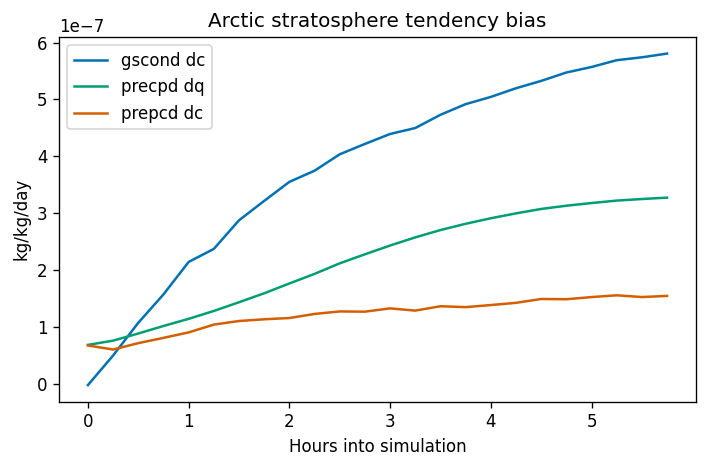

In [208]:

plt.figure(dpi=120)
gscond_cl_bias.plot(label="gscond dc")
precpd_q_bias.plot(label="precpd dq")
precpd_cl_bias.plot(label="prepcd dc")
plt.title("Arctic stratosphere tendency bias")
plt.ylabel("kg/kg/day")
plt.xlabel("Hours into simulation")
plt.xticks(ticks=np.arange(24,step=4), labels=[f"{int((i+1)/4):1d}" for i in np.arange(24, step=4)])
plt.legend()
plt.tight_layout()
plt.show()

In [209]:
gscond_cl_bias.isel(time=0)

<xarray.DataArray 'bias' ()>
array(-2.74045532e-09)

In [213]:
from itertools import product

def _get_hour(tidx, stop_arg=False, num_times=24):
    if tidx is None:
        if stop_arg:
            return num_times / 4
        else:
            return 0
    elif tidx < 0:
        return (num_times + tidx) / 4
    else:
        return tidx / 4

def load_polar_strat_tends_at_timerange(key, slice_args):
    return arctic_tendencies[key].isel(time=slice(*slice_args)).to_dataset(name=key).load()

def get_hr_str_from_trange(trange):
    if len(trange) == 1:
        return f"hours 0-{_get_hour(trange[0], stop_arg=True):1.1f}"
    else:
        return f"hours {_get_hour(trange[0], stop_arg=False):1.1f}-{_get_hour(trange[1], stop_arg=True):1.1f}"

def get_flat_above_thresh(data, threshold=1e-15):
    data = data.where(abs(data) > threshold).values.flatten()
    mask = np.isfinite(data)
    return data[mask]

def plot_symlog_hist_compare(subroutine="gscond", time_ranges=((1,), (11, 13), (-4, None))):
    bins = np.logspace(-20, -8, 50)
    full_bins = np.concatenate([-bins[::-1], bins])

    keys = [get_key(*args) for args in product([subroutine], ["emulator", "physics"], ["dq", "dc"])]
    for trange in time_ranges:
        plt.figure(dpi=120)
        
        bins = np.logspace(-15, -9, 50)
        for key in keys:
            if subroutine == "gscond" and "dq" in key:
                continue
            
            data = load_polar_strat_tends_at_timerange(key, trange)[key]
            flat = get_flat_above_thresh(data)

            if "physics" in key:
                lstyle = "--"
            else:
                lstyle = "-"

            plt.hist(flat, bins=full_bins, histtype="step", label=key, log=True, linestyle=lstyle)
        plt.xscale("symlog", linthreshx=1e-15)
        plt.legend(loc="upper center")
        plt.title(f"{subroutine} tendency histogram:  {get_hr_str_from_trange(trange)}")
        plt.show()

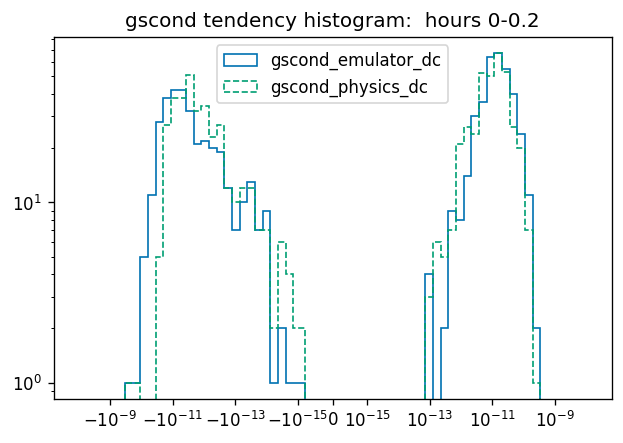

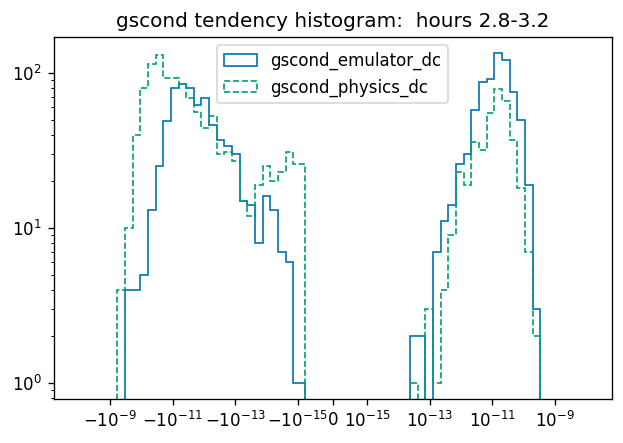

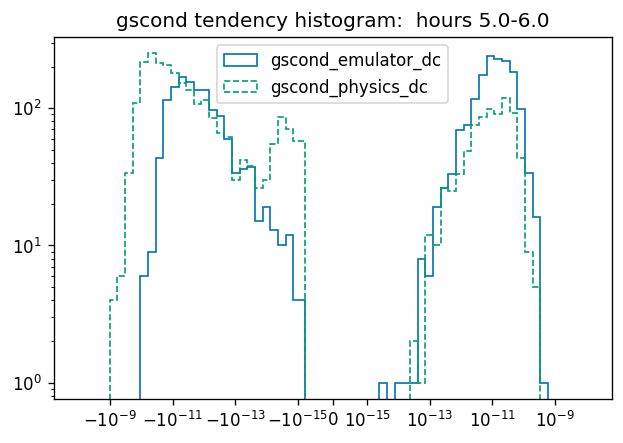

In [214]:
plot_symlog_hist_compare(subroutine="gscond")

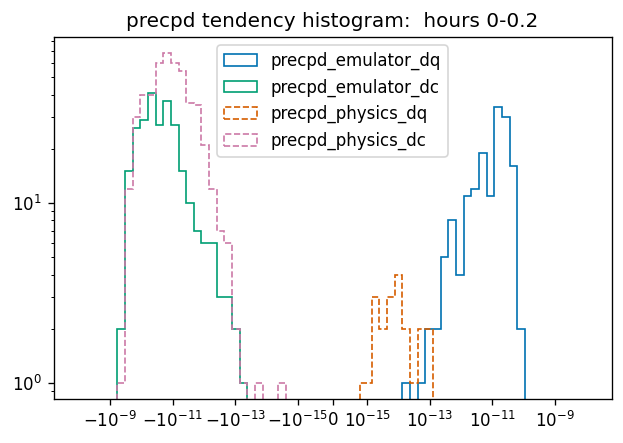

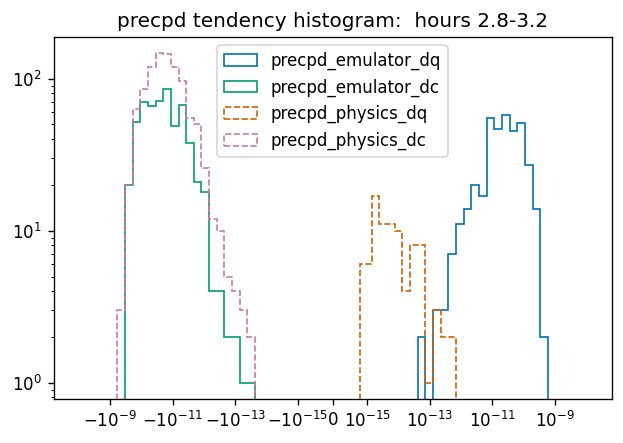

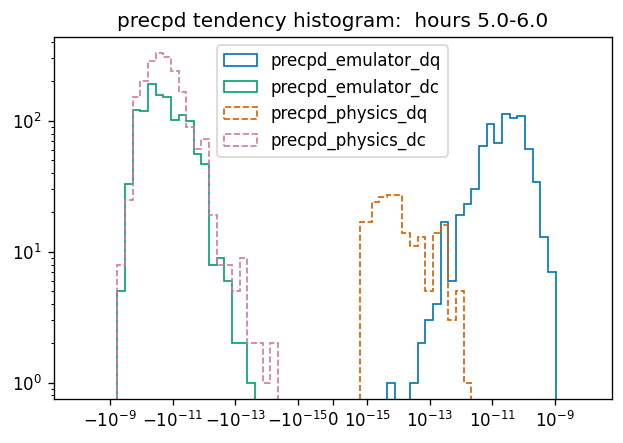

In [215]:
plot_symlog_hist_compare(subroutine="precpd")